<a href="https://colab.research.google.com/github/pratikiiitb2013/ERA/blob/main/S7/ERA1S7Code10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        transforms.RandomRotation((-15.0, 15.0), fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
### Normalize needs tensor(not np array)
# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 220108907.68it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 62152741.83it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 93232470.06it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 22545004.46it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [ ]:
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 28, 26

    # CONVOLUTION BLOCK 1
    self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(13),
            nn.ReLU()
    ) # output_size = 28, 24
    # self.convblock3 = nn.Sequential(
    #         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
    #         nn.ReLU()
    #     ) # output_size = 22

    # TRANSITION BLOCK 1
    self.mp1 = nn.MaxPool2d(2, 2) # output_size = 14
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=13, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        # nn.BatchNorm2d(8),
        # nn.ReLU()
    ) # output_size = 14, 12

    # CONVOLUTION BLOCK 2
    self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
    ) # output_size = 14, 10
    self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 14, 8

    # TRANSITION BLOCK 2
    # self.mp2 = nn.MaxPool2d(2, 2) # output_size = 7
    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        # nn.BatchNorm2d(10),
        # nn.ReLU()
    ) # output_size = 7, 8

    # OUTPUT BLOCK
    self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
        nn.BatchNorm2d(20),
        nn.ReLU()
    )
    self.convblock8 = nn.Sequential(
        nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        nn.BatchNorm2d(10),
        nn.ReLU()
    )
     # output_size = 7, 6
    # self.convblock8 = nn.Sequential(
    #     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
    #     nn.ReLU()
    # )# output_size = 7, 4
    # self.convblock9 = nn.Sequential(
    #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(6, 6), padding=0, bias=False),
    # )# output_size = 1
    self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4) # 7>> 9... nn.AdaptiveAvgPool((1, 1))
        ) # output_size = 1
    self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )
    self.dropout = nn.Dropout(0.1)


  def forward(self, x):
    x = self.dropout(self.convblock2(self.dropout(self.convblock1(x))))
    x = self.mp1(x)
    x = self.convblock3(x)
    x = self.dropout(self.convblock5(self.dropout(self.convblock4(x))))
    # x = self.mp2(x)
    x = self.convblock6(x)
    # x = self.convblock9(self.convblock8(self.convblock7(x)))
    x = self.gap(self.convblock8(self.convblock7(x)))
    x = self.convblock9(x)
    x = x.view(-1, 10) #1x1x10> 10
    return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# model = Net().to(device)
model = Net2().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 13, 24, 24]           1,170
       BatchNorm2d-6           [-1, 13, 24, 24]              26
              ReLU-7           [-1, 13, 24, 24]               0
           Dropout-8           [-1, 13, 24, 24]               0
         MaxPool2d-9           [-1, 13, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             104
           Conv2d-11           [-1, 10, 10, 10]             720
      BatchNorm2d-12           [-1, 10, 10, 10]              20

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # print(correct)
    # print(processed)
    # print(len(train_losses))

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
# model =  Net().to(device)

from torch.optim.lr_scheduler import StepLR



model =  Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.22314105927944183 Batch_id=468 Accuracy=83.12: 100%|██████████| 469/469 [00:24<00:00, 18.94it/s]



Test set: Average loss: 0.1078, Accuracy: 9724/10000 (97.24%)

EPOCH: 1


Loss=0.1598997712135315 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:21<00:00, 21.61it/s]



Test set: Average loss: 0.0650, Accuracy: 9810/10000 (98.10%)

EPOCH: 2


Loss=0.09224933385848999 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:21<00:00, 21.49it/s]



Test set: Average loss: 0.0403, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.05737675353884697 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]



Test set: Average loss: 0.0353, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.1166665330529213 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:22<00:00, 21.16it/s]



Test set: Average loss: 0.0310, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.1306779533624649 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]



Test set: Average loss: 0.0273, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.05421112850308418 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]



Test set: Average loss: 0.0265, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.1093674972653389 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]



Test set: Average loss: 0.0265, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.1321142017841339 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]



Test set: Average loss: 0.0264, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.01651970110833645 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]



Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.09108271449804306 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]



Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.051271870732307434 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]



Test set: Average loss: 0.0222, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.049042921513319016 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]



Test set: Average loss: 0.0217, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.018238352611660957 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]



Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.018951479345560074 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]



Test set: Average loss: 0.0196, Accuracy: 9939/10000 (99.39%)



In [ ]:
# train_losses

In [ ]:
t = [t_items.item() for t_items in train_losses]
len(t)

7035

Text(0.5, 1.0, 'Test Accuracy')

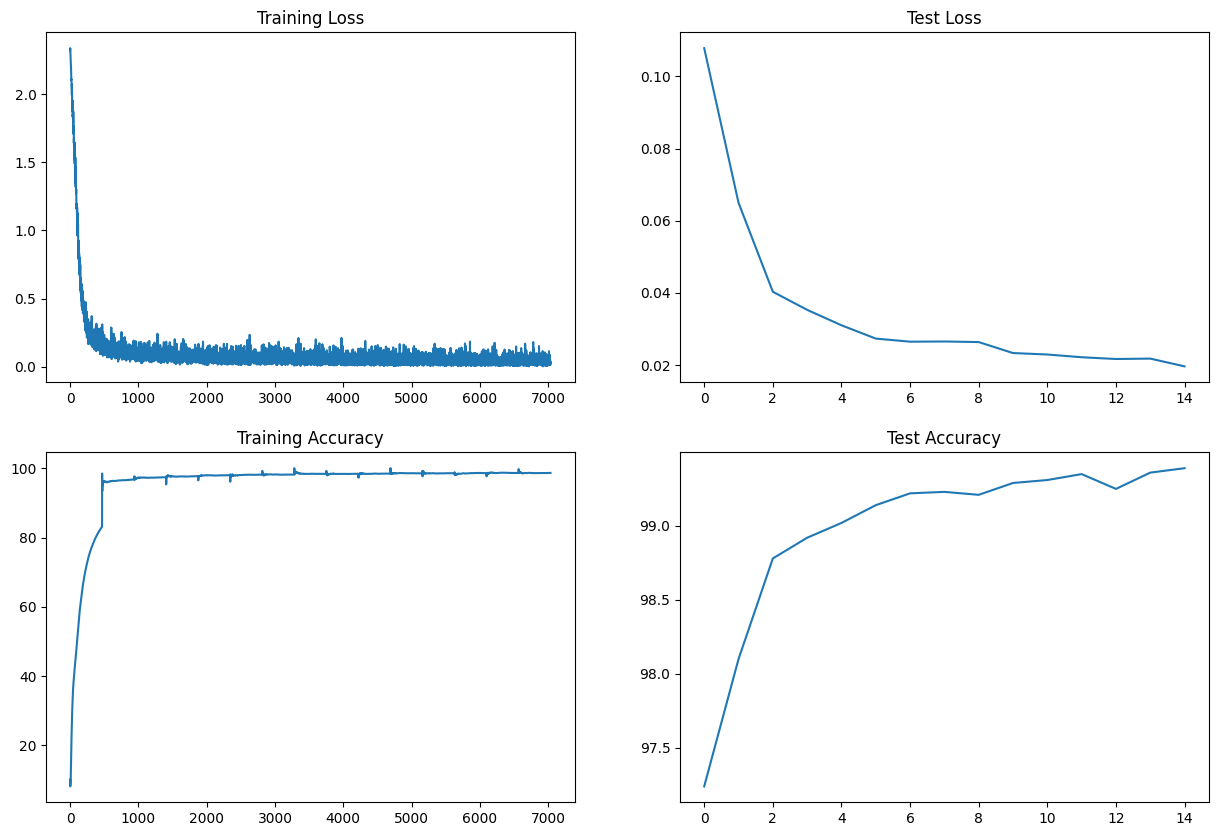

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
##Add LR Scheduler